# Import Libraries

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Obtain Data

Read S&P 500 data csv into pandas df

In [106]:
df = pd.read_csv('Data/Prices.csv')
df.head()

,Date,Open,High,Low,Close
0,12/31/19,3215.18,3231.72,3212.03,3230.78
1,12/30/19,3240.09,3240.92,3216.57,3221.29
2,12/27/19,3247.23,3247.93,3234.37,3240.02
3,12/26/19,3227.20,3240.08,3227.20,3239.91
4,12/24/19,3225.45,3226.43,3220.51,3223.38


# Scrub Data

See what data scrubbing needed with df.info

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2724 non-null   object 
 1    Open   2724 non-null   float64
 2    High   2724 non-null   float64
 3    Low    2724 non-null   float64
 4    Close  2724 non-null   float64
dtypes: float64(4), object(1)
memory usage: 106.5+ KB


Drop df columns not useful for modeling

In [108]:
df.drop(columns=[' Open', ' High', ' Low'], inplace=True)
df.head()

,Date,Close
0,12/31/19,3230.78
1,12/30/19,3221.29
2,12/27/19,3240.02
3,12/26/19,3239.91
4,12/24/19,3223.38


Rename Close column to S&P 500 Closing Price

In [109]:
df.rename(columns= {' Close': 'S&P Closing Price'}, inplace=True)
df.head()

,Date,S&P Closing Price
0,12/31/19,3230.78
1,12/30/19,3221.29
2,12/27/19,3240.02
3,12/26/19,3239.91
4,12/24/19,3223.38


Change Date column to datetime data type

In [110]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.head()

,Date,S&P Closing Price
0,2019-12-31,3230.78
1,2019-12-30,3221.29
2,2019-12-27,3240.02
3,2019-12-26,3239.91
4,2019-12-24,3223.38


Order datapoints in ascending order by date

In [111]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Date,S&P Closing Price
0,2009-03-09,676.53
1,2009-03-10,719.60
2,2009-03-11,721.36
3,2009-03-12,750.74
4,2009-03-13,756.55


Confirm dataset now scrubbed with df.info

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2724 non-null   datetime64[ns]
 1   S&P Closing Price  2724 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.7 KB


# Explore Data

Calculate time series descriptive statistics

In [113]:
df['S&P Closing Price'].describe()

count    2724.000000
mean     1887.204710
std       624.475244
min       676.530000
25%      1319.002500
50%      1924.605000
75%      2374.440000
max      3240.020000
Name: S&P Closing Price, dtype: float64

Plot time series dataset

<ipython-input-114-d0c82e76c402>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(date_labels)


Text(0, 0.5, 'Closing Price')

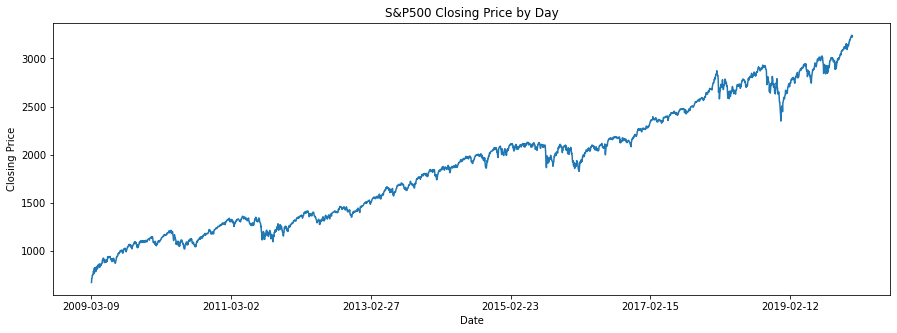

In [114]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['S&P Closing Price'].values)
date_labels = [0]
date_labels.extend([str(df.loc[x, 'Date']).split(' ')[0] for x in range(0, 3000, 500)])
ax.set_xticklabels(date_labels)
ax.set_title('S&P500 Closing Price by Day')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

# Model Data

Difference time series data

In [115]:
df['Differenced Price'] = df[['S&P Closing Price']].diff(periods=1)
df.head()

,Date,S&P Closing Price,Differenced Price
0,2009-03-09,676.53,NaN
1,2009-03-10,719.60,43.07
2,2009-03-11,721.36,1.76
3,2009-03-12,750.74,29.38
4,2009-03-13,756.55,5.81


Plot differenced time series data

<ipython-input-116-cb91582f368d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(date_labels)


Text(0, 0.5, 'Closing Price')

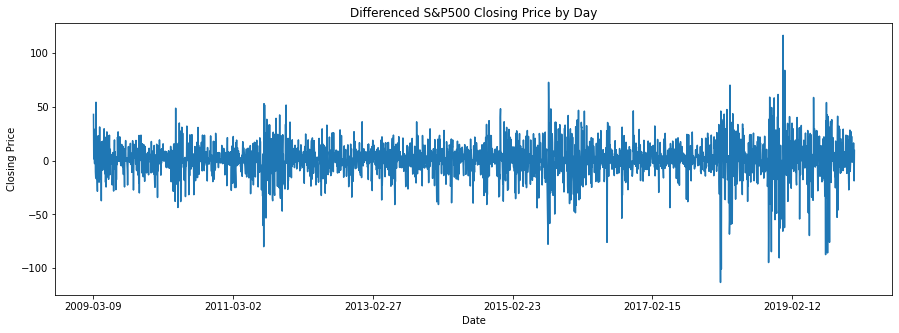

In [116]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['Differenced Price'].values)
date_labels = [0]
date_labels.extend([str(df.loc[x, 'Date']).split(' ')[0] for x in range(0, 3000, 500)])
ax.set_xticklabels(date_labels)
ax.set_title('Differenced S&P500 Closing Price by Day')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

Run Dickey-Fuller test on differenced time series data

In [117]:
adfuller(df['Differenced Price'][1:])

(-12.998412457721754,
 2.7193325008130615e-24,
 18,
 2704,
 {'1%': -3.43277067999415,
  '5%': -2.862609479032774,
  '10%': -2.567339319094438},
 22911.05603338416)

Plot time series acf

Text(0, 0.5, 'Correlation')

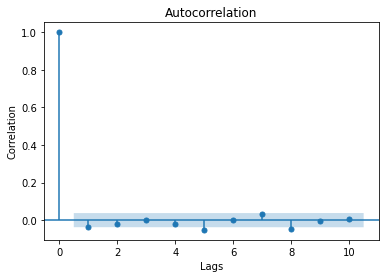

In [123]:
fig, ax = plt.subplots()
plot_acf(df['Differenced Price'][1:], alpha=.05, lags = 10, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Plot time series pacf

Text(0, 0.5, 'Correlation')

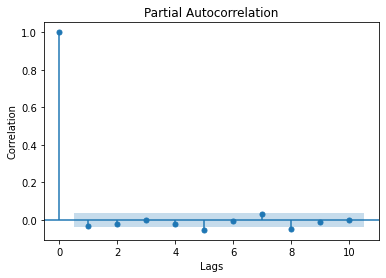

In [121]:
fig, ax = plt.subplots()
plot_pacf(df['Differenced Price'][1:], alpha=.05, lags = 10, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')